# Outliers detection
Outlier detection is a technique used in data analysis to identify observations or samples that significantly differ from the rest of the dataset. An outlier is a value that deviates considerably from the general trend of the data, which can be due to measurement errors, data noise, or rare and anomalous events that do not follow the overall pattern.

Outlier detection is important because these exceptional values can have a significant impact on data analysis results and machine learning models if not handled properly. Outliers can bias descriptive statistics, affect the accuracy and interpretation of models, and lead to incorrect decisions.

In the context of clustering (data grouping), outlier detection is particularly relevant. Outliers can distort the structure of clusters, causing clustering algorithms to assign outliers to existing groups or even generate artificial clusters to accommodate outlier values. This can result in unrepresentative or less meaningful clusters.

## Libraries
Libraries to be used during code development are imported.

In [1]:
import tkinter as tk
from tkinter.filedialog import askopenfilename
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import scipy as sp

## Import Database 
In this section of the script the data to be plotted is imported. It is required that the file to work with is in a comma separated text format ".csv". Then a summary table with database statistics is generated.

In [2]:
root = tk.Tk()
root.withdraw()
database_file = askopenfilename(filetypes=[("csv files", "*.csv")])

data = pd.read_csv(database_file, na_values=[-999.25])

## Add a Sequential column to the DataFrame

In [3]:
seq = np.linspace(1, data['MD'].count(), data['MD'].count())
data.insert(0, 'Sequential', seq.tolist())

In [4]:
columnas_a_eliminar = ['MD', 'Sequential']
data.drop(columnas_a_eliminar, axis=1, inplace=True)

## Scale the data using StandardScaler

In [5]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
datascaled = pd.DataFrame(data_scaled)
datascaled.columns = data.columns

## Robust Mahalonibis Distance

Mahalanobis Distance for Outlier Detection with IQR Threshold:

The Mahalanobis distance is a powerful tool for detecting outliers in multivariate datasets, considering the correlations between variables. When combined with the Interquartile Range (IQR) threshold, it offers a robust method to identify outliers and handle them effectively.

Mahalanobis Distance for Outlier Detection:

As mentioned earlier, the Mahalanobis distance measures the distance between a data point $\mathbf{x}$ and the centroid of the dataset, taking into account the covariance matrix $\mathbf{\Sigma}$. The formula for calculating the Mahalanobis distance is given by:

$D_{M}(\mathbf{x}) = \sqrt{(\mathbf{x} - \mathbf{μ})^\top \mathbf{Σ}^{-1} (\mathbf{x} - \mathbf{μ})}$
 

Here, $\mathbf{x}$ is the vector of the data point's features, $\boldsymbol{\mu}$ is the mean vector of the dataset, and $\mathbf{\Sigma}$ is the covariance matrix.

IQR Threshold for Outlier Detection:

The Interquartile Range (IQR) is a measure of statistical dispersion, representing the range between the first quartile $Q1$ and the third quartile $Q3$ of the dataset. The $IQR$ is calculated as:

$IQR=Q3−Q1$

To identify outliers using the IQR method, we define a lower threshold $(Q1 - k \times IQR)$ and an upper threshold $(Q3 + k \times IQR)$, where $k$ is a user-defined constant (typically set to 1.5 or 3). Data points falling below the lower threshold or above the upper threshold are considered outliers.

Combining Mahalanobis Distance and IQR Threshold:

To leverage the benefits of both approaches, we can use the Mahalanobis distance to consider the correlations between variables and then apply the IQR threshold for robust outlier detection. The steps for this combined method are as follows:

Calculate the Mahalanobis distance $D_{M}(\mathbf{x})$ for each data point $\mathbf{x}$ in the dataset, considering the covariance matrix $\mathbf{\Sigma}$ and the mean vector $\boldsymbol{\mu}$.

Calculate the IQR using the first quartile $Q1$ and the third quartile $Q3$ of the dataset.

Define the lower threshold $(Q1 - k \times IQR)$ and the upper threshold $(Q3 + k \times IQR)$, where $k$ is a chosen constant.

Flag data points with Mahalanobis distance greater than the upper threshold or less than the lower threshold as outliers.

By combining the Mahalanobis distance and the IQR threshold, we can identify outliers in multivariate datasets more effectively, taking into account both the covariance between variables and the robustness of the IQR measure. This combined approach allows for a more comprehensive and reliable outlier detection, particularly in scenarios where datasets exhibit complex correlations and non-normal distributions.


In [6]:
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    # Calculate IQR-based threshold for outliers
    Q1 = np.percentile(md, 25)
    Q3 = np.percentile(md, 75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR  # You can adjust the multiplier (1.5) as needed
    
    #Flag as outlier
    outlier = []
    for index, value in enumerate(md):
        if value > threshold:
            outlier.append(index)
        else:
            continue
    return outlier, md

## Detect outliers using the robust Mahalanobis method

In [7]:
outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=datascaled)
data['outliers'] = np.where(data.index.isin(outliers_mahal_rob), -1, 1)

## Visualize the distribution of outliers

Number of inliers: 7140
Number of outliers: 373
Total: 7513


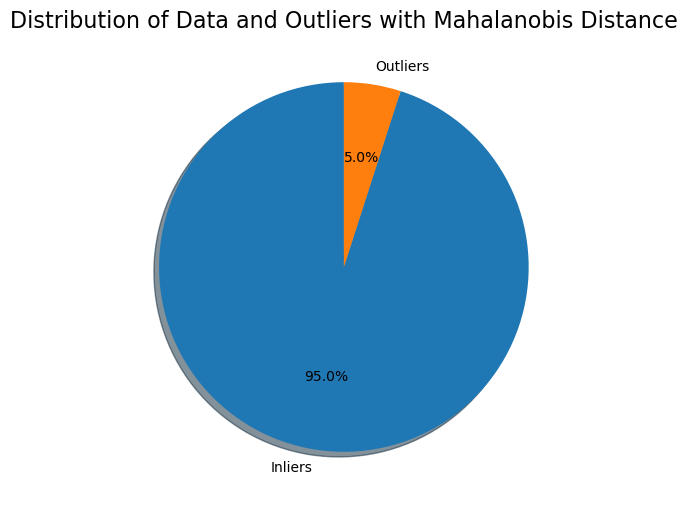

In [8]:
n_inliers = (data['outliers'] == 1).sum()
n_outliers = (data['outliers'] == -1).sum()
n_total = n_inliers + n_outliers

print(f"Number of inliers: {n_inliers}")
print(f"Number of outliers: {n_outliers}")
print(f"Total: {n_total}")

labels = 'Inliers', 'Outliers'
sizes = [n_inliers, n_outliers]
plt.rcParams["figure.facecolor"] = "w"
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribution of Data and Outliers with Mahalanobis Distance', size=16)
plt.show()

## Create a pair plot of the data with outliers highlighted

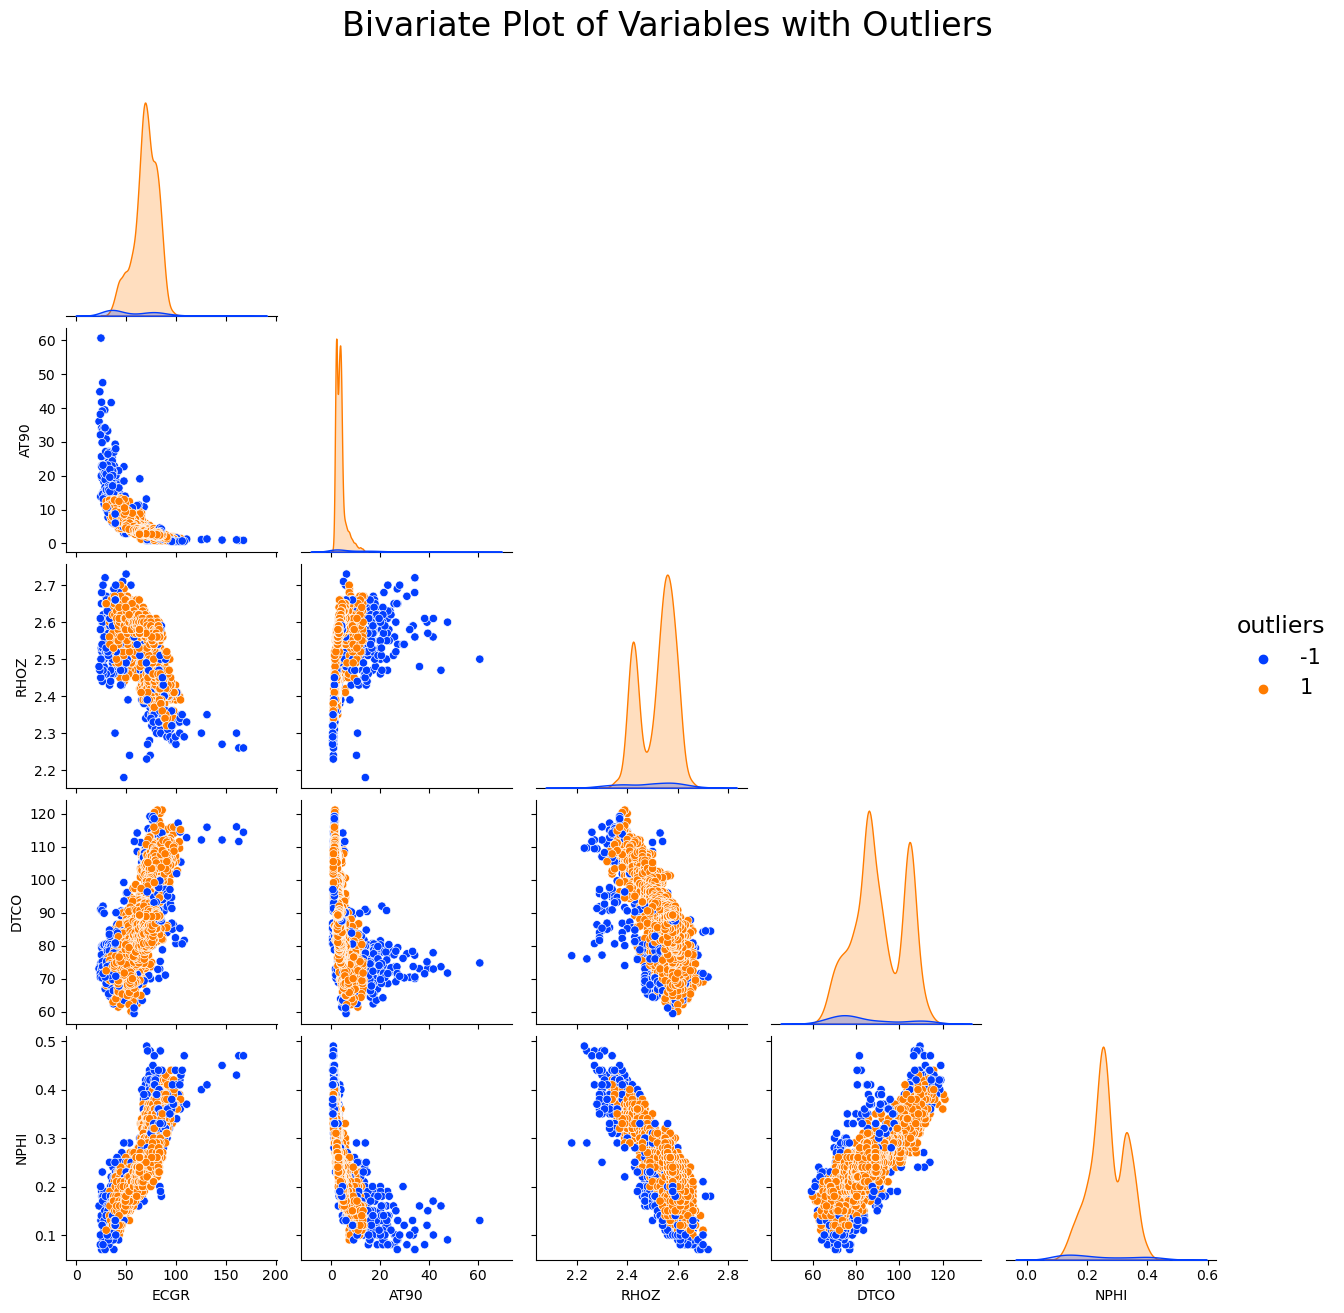

In [9]:
ds = data.copy()

plt.rc('legend', fontsize=15, title_fontsize=17)
plt.rc('axes', titlesize=25)
sns.pairplot(ds, hue='outliers', palette='bright', corner=True)
plt.suptitle('Bivariate Plot of Variables with Outliers', size=24, y=1.05)
plt.show()

## Optional: Save the DataFrame of inliers for further analysis

In [10]:
data_inliers = data[data['outliers'] == 1].drop('outliers', axis=1)

In [11]:
data_inliers.describe().apply(lambda s: s.apply('{0:.4f}'.format))

,ECGR,AT90,RHOZ,DTCO,NPHI
count,7140.0000,7140.0000,7140.0000,7140.0000,7140.0000
mean,69.4753,3.6705,2.5179,90.6197,0.2691
std,11.9478,2.0003,0.0702,11.8749,0.0604
min,30.1600,0.8000,2.3200,60.0400,0.0900
25%,63.2100,2.2000,2.4400,82.7875,0.2300
50%,70.3100,3.3200,2.5400,88.6400,0.2600
75%,78.3125,4.1600,2.5700,102.9400,0.3200
max,104.6600,13.8300,2.7000,121.1300,0.4400


In [ ]:
data_inliers.to_csv('data_inliers.csv', index=False)